In [1]:
!pip install kmodes
!pip install currencyconverter 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra,array
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import re
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def load_data(path):
 return pd.read_excel(path)

In [0]:
def replace_characters(df, val, by, is_regex):
  return df.replace(to_replace = val, value = by, regex= is_regex ) 


# Load Data 

In [5]:
path = 'Data2.xlsx'
df = load_data(path)
df = replace_characters(df, "—", np.nan , True)
df = replace_characters(df, "—\r\n", np.nan , True)
df.head()

,Unnamed: 0,Name,Type,Headquaters,Status,Founded Year,Investment Stage,Exit Date,Purpose,Number of Investment,Number of Lead Investment,Estimated Revenue,Founders,Number of employees,Funding Rounds,Funding Status,Active Products,Funding Amount,Nunmber of Lead Investors,Nmber of Investors,Acquired Price,Acquisitions,Acquisition Status,Acquired By,IPO status,Full Name,Job Title,Primary Organization,Founded Organization,Portfolio Companies
0,0,1. Cloudflare,"Ad Server, Advertising, Analytics, Enterprise...","San Francisco, California, United States",Active,Jun 2009,NaN,"Sep 12, 2019",For Profit,NaN,NaN,$100M to $500M,3,501-1000,6,IPO,106,"$332,050,000",7,12,NaN,5,Made Acquisitions\r\n,NaN,Public,251. Eran Shir,Co-founder & CEO,Nexar,2,1
1,1,2. GumGum,"Advertising, Advertising Platforms, Analytics...","Santa Monica, California, United States",Active,2008,NaN,NaN,For Profit,NaN,NaN,$1M to $10M,2,251-500,6,Late Stage Venture,34,"$58,825,000",5,7,NaN,NaN,NaN,NaN,Private,252. Mitch Liu,Co-Founder & Chief Executive Officer,Sliver.tv,4,NaN
2,2,3. Authentic Brands Group,"Advertising, Brand Marketing, Marketing, Retail","New York, New York, United States",Active,2010,NaN,NaN,For Profit,1,NaN,$1B to $10B,1,251-500,3,Private Equity,5,"$875,000,000",2,5,NaN,9,Made Acquisitions\r\n,NaN,Private,253. Amiad Solomon,Chairman & Co-Founder,Komoona,6,NaN
3,3,4. Hootsuite,"Advertising, Apps, Brand Marketing, Messaging...","Vancouver, British Columbia, Canada",Active,"Nov 28, 2008",NaN,NaN,For Profit,NaN,NaN,$10M to $50M,3,501-1000,6,Late Stage Venture,157,"$299,693,624",7,12,NaN,12,Made Acquisitions\r\n,NaN,Private,254. Erik Berlin,CEO & Founder,Breaker,2,NaN
4,4,5. Tubi,"Advertising, Digital Entertainment, Film, Med...","San Francisco, California, United States",Active,2014,NaN,NaN,For Profit,NaN,NaN,$1M to $10M,1,101-250,3,Late Stage Venture,23,"$26,000,000",1,13,NaN,NaN,NaN,NaN,Private,255. Reese Jones,NaN,NaN,4,NaN


# Data Cleaning

## 1. Check for percentage of null values 

In [6]:
feature_with_nan = [features for features in df.columns if df[features].isnull().sum()>1 and df[features].dtype == 'O']
len(feature_with_nan)

for features in feature_with_nan:
    print('{}: {}% missing value'.format(features, np.around(df[features].isnull().mean()*100,4)))

Headquaters: 0.07% missing value
Founded Year: 0.66% missing value
Investment Stage: 98.97% missing value
Exit Date: 79.12% missing value
Purpose: 18.53% missing value
Number of Investment: 91.83% missing value
Number of Lead Investment: 94.77% missing value
Estimated Revenue: 37.45% missing value
Founders: 14.55% missing value
Number of employees: 7.69% missing value
Funding Rounds: 6.16% missing value
Funding Status: 26.19% missing value
Active Products: 25.67% missing value
Funding Amount: 6.96% missing value
Nunmber of Lead Investors: 27.74% missing value
Nmber of Investors: 14.28% missing value
Acquired Price: 95.64% missing value
Acquisitions: 79.71% missing value
Acquisition Status: 71.1% missing value
Acquired By: 86.66% missing value
Job Title: 10.59% missing value
Primary Organization: 10.58% missing value
Portfolio Companies: 68.55% missing value


## 2. Analyze Feature Data Type and Values

In [7]:
#numericals features
numerical_feature = [feature for feature in df.columns if df[feature].dtype != 'O']  
print('Number of numerical variables:', len(numerical_feature))  

Number of numerical variables: 2


In [8]:
#categorical feature
categorical_feature = [feature for feature in df.columns if df[feature].dtype == 'O']  
print('Number of categorical variables:', len(categorical_feature))  
categorical_feature

Number of categorical variables: 28


['Name',
 'Type',
 'Headquaters',
 'Status',
 'Founded Year',
 'Investment Stage',
 'Exit Date',
 'Purpose',
 'Number of Investment',
 'Number of Lead Investment',
 'Estimated Revenue',
 'Founders',
 'Number of employees',
 'Funding Rounds',
 'Funding Status',
 'Active Products',
 'Funding Amount',
 'Nunmber of Lead Investors',
 'Nmber of Investors',
 'Acquired Price',
 'Acquisitions',
 'Acquisition Status',
 'Acquired By',
 'IPO status',
 'Full Name',
 'Job Title',
 'Primary Organization',
 'Portfolio Companies']

In [9]:
#number of categories in each feature
for feature in categorical_feature:
    print('The feature is {} and number of categories are {}'.format(feature, len(df[feature].unique())))


The feature is Name and number of categories are 10000
The feature is Type and number of categories are 7679
The feature is Headquaters and number of categories are 1560
The feature is Status and number of categories are 2
The feature is Founded Year and number of categories are 1915
The feature is Investment Stage and number of categories are 38
The feature is Exit Date and number of categories are 1432
The feature is Purpose and number of categories are 3
The feature is Number of Investment and number of categories are 83
The feature is Number of Lead Investment and number of categories are 52
The feature is Estimated Revenue and number of categories are 9
The feature is Founders and number of categories are 13
The feature is Number of employees and number of categories are 10
The feature is Funding Rounds and number of categories are 24
The feature is Funding Status and number of categories are 7
The feature is Active Products and number of categories are 170
The feature is Funding 

## Common Functions

In [0]:
def join_column_vals(df,column,sep):
  df_temp = sep.join(df[column])
  values = df_temp.split(sep)
  return pd.DataFrame(values,columns=[column]) 

In [0]:
def join_and_count(df, column, sep, sort):
  temp_df = join_column_vals(df, column, sep)
  value_counts = temp_df[column].value_counts()
  value_counts = value_counts.sort_values(ascending=sort)
  return value_counts;

In [0]:
def replace_with_top_n(df,top_df,column,sep,replace_others):
  temp_df = []
  for row in df[column]:
    vals = row.split(sep)
    intersect = [x for x in vals if x in top_df.index]
    strg = sep.join([str(elem) for elem in intersect])
    if not strg:
      strg = replace_others
    temp_df.append(strg)
  return temp_df


In [0]:
def plot_bar_plot(category_count,title,xlabel,ylabel,color,img):
  plt.figure(figsize=(14,8))
  bar_plot = sns.barplot(x =category_count.index, y = category_count.values,palette=color)
  sns.set_style("white")
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  locs, labels = plt.xticks()
  plt.setp(labels, rotation=90)
  for j,i in enumerate(bar_plot.patches):
    height = i.get_height()
    bar_plot.text(i.get_x() + i.get_width()/2, height + 5, category_count[j], ha='center', va='bottom')
  plt.savefig(img,bbox_inches='tight')

## 1. Clean Acquisition Status

In [14]:
df['Acquisition Status'].value_counts()

 Made Acquisitions\r\n                  1558
 Was Acquired\r\n                        861
 Made Acquisitions, Was Acquired\r\n     471
Name: Acquisition Status, dtype: int64

Labels were mislabelled and should be handeled


1.   NaN - No Participation
2.   Made Acquisitions - Acquisition 
3.   Was Acquired - Acquisition
4.   Made Acquisitions, Was Acquired - Merger



In [0]:
# Merge Acquisition Status

df['Acquisition Status'] = df['Acquisition Status'].astype(str)
df['Acquisition Status'] = df['Acquisition Status'].map(lambda x: re.sub(r'\W+', '', x))
df['Acquisition Status'] = df['Acquisition Status'].replace(to_replace ="MadeAcquisitionsWasAcquired", value = "Merger")
df['Acquisition Status'] = df['Acquisition Status'].replace(to_replace ="WasAcquired", value = "Acquisition")
df['Acquisition Status'] = df['Acquisition Status'].replace(to_replace ="MadeAcquisitions", value = "Acquisition")
df['Acquisition Status'] = df['Acquisition Status'].replace(to_replace ='nan',value = 'No Participation')

There are 3 different acquisition statuses in our Dataset


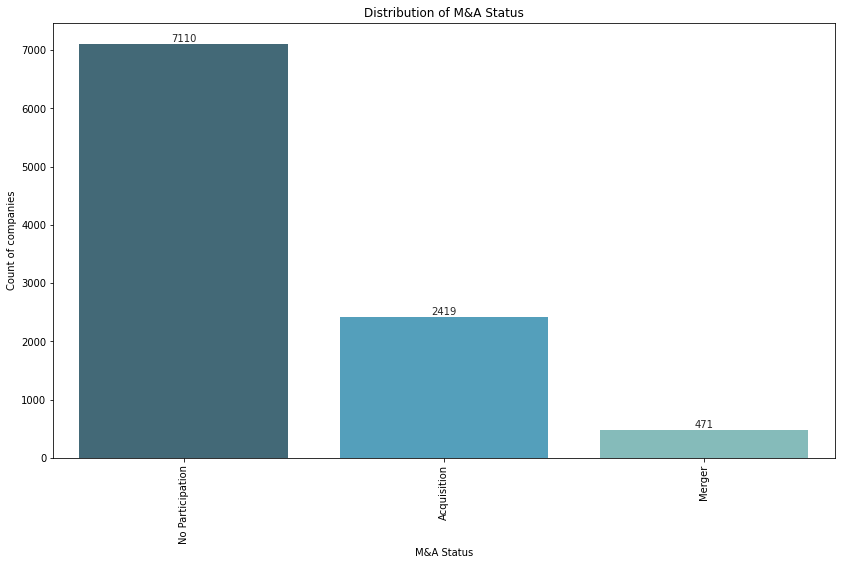

In [16]:
#count of all companies with the given 3 acquisition statuses

acqstat = df['Acquisition Status'].value_counts()
print('There are',len(acqstat),'different acquisition statuses in our Dataset')
plot_bar_plot(acqstat, "Distribution of M&A Status", "M&A Status", "Count of companies", 'GnBu_d', 'acq_status.png')


## 2. Clean Acquisitions

In [17]:
df['Acquisitions'].value_counts()
df['Acquisitions'].isnull().sum()


7971

It contains 7k null values. We must consider dropping the column

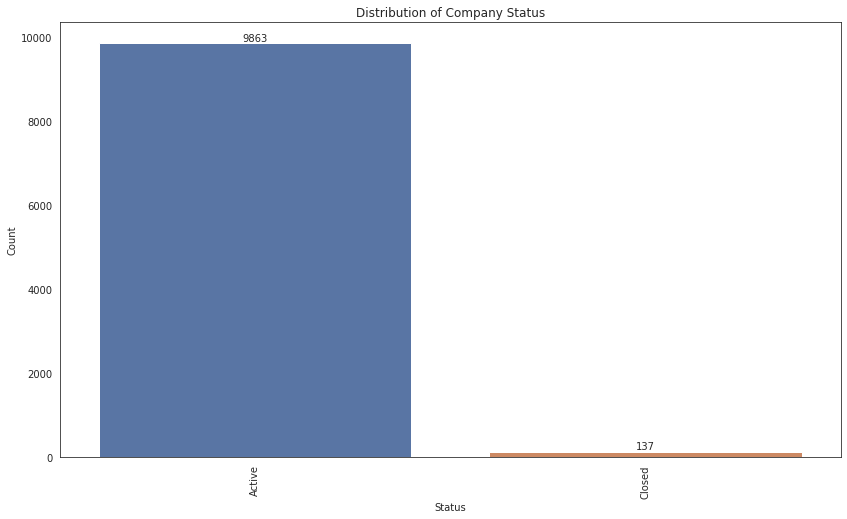

In [18]:
status_count = df['Status'].value_counts()
plot_bar_plot(status_count, "Distribution of Company Status", "Status", "Count", 'deep', 'Company_Status.png')


## 3. Normalize Active Products

In [19]:
import plotly.express as px
fig = px.box(df, y='Active Products', hover_data= ["Active Products"], width=400, height=400)
fig.update_layout(
    yaxis = dict(range=[0, 500]),
    yaxis_title="Active Products Distribution",
    font=dict(
         size=12
    )
)
fig.show()

In [0]:
def normalize_outliers(data):
    threshold = 1.5
    for col in data.columns:
      normalized_data = []
      mean = np.mean(data[col])
      std = np.std(data[col])
      for y in data[col]:
          z_score= (y - mean)/std
          if np.abs(z_score) > threshold:
            normalized_data.append(mean)
          else:
            normalized_data.append(y)
      data[col] = normalized_data
    return data

In [21]:

z = pd.DataFrame(df['Active Products'].astype(float))
z['Active Products'] = z.fillna(z['Active Products'].astype(float).mean())
print(df['Active Products'].astype(float).mean())
print(df['Active Products'].astype(float).median())
print(df['Active Products'].astype(float).std())
z = normalize_outliers(z)


23.64671061482578
18.0
25.937404628002522


In [0]:
#binning Active products
df['Active Products'] = z
df['Active Products']= df['Active Products'].astype(float) 
df['Active Products']=pd.cut(df['Active Products'], bins=[-1,10.0,22.0,30.0,60.0], labels = ["1-10","11-22","23-30","31-60"])


In [23]:
import plotly.express as px
fig = px.box(z, y='Active Products', hover_data= ["Active Products"], width=400, height=400)
fig.update_layout(
    yaxis = dict(range=[0, 150]),
    yaxis_title="Active Product Distribution",
    font=dict(
         size=12
    )
)
fig.show()

## 4. Clean Funding Status

In [0]:
# funding status replace with mode

val = df['Funding Status'].mode()
df['Funding Status'] = df['Funding Status'].fillna('Early Stage Venture')


There are a total of  6 different Funding Status in our dataset
Early Stage Venture    4997
Seed                   1641
M&A                    1332
Late Stage Venture      995
IPO                     756
Private Equity          279
Name: Funding Status, dtype: int64


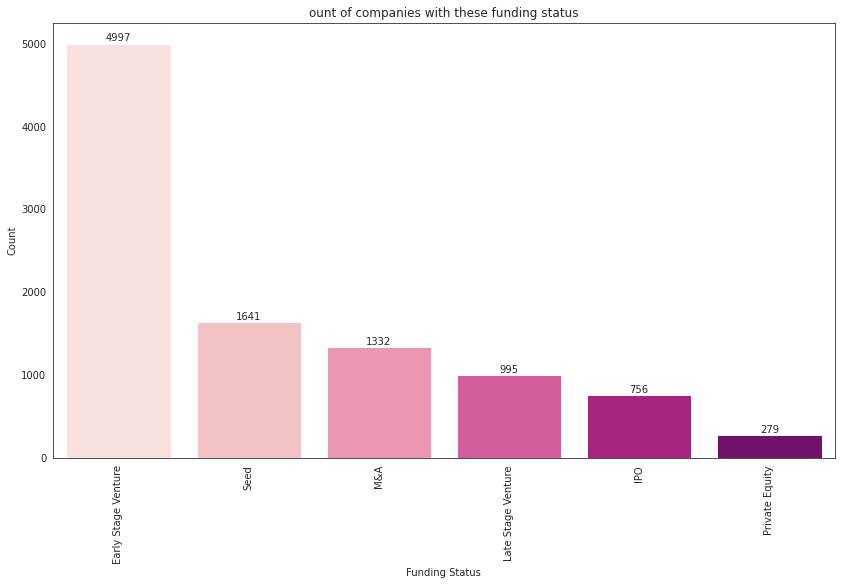

In [25]:
fund_status_count = df['Funding Status'].value_counts()
print('There are a total of ',len(fund_status_count),'different Funding Status in our dataset')
print(fund_status_count)
plot_bar_plot(fund_status_count, 'ount of companies with these funding status', "Funding Status", 
              "Count", 'RdPu', 'funding_status.png')


# Feature Engineering

## 1. Create a new Column for Founding Year from Existing one

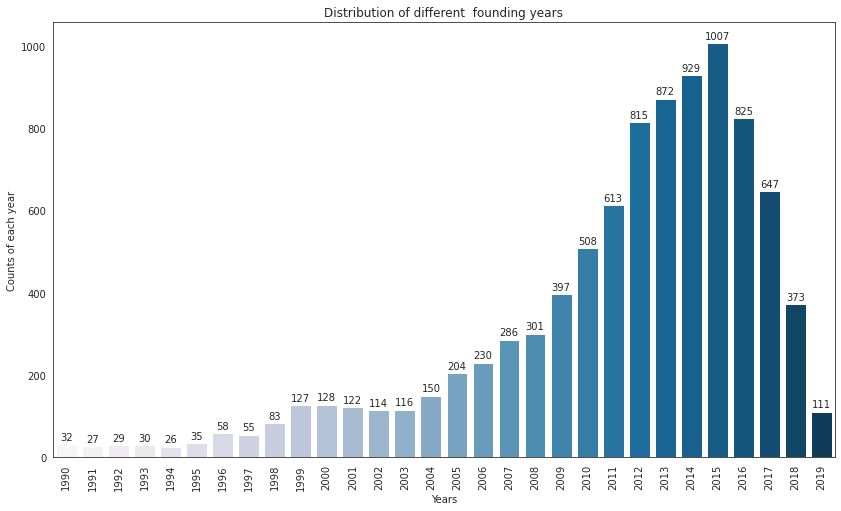

In [26]:

founded_y = []
founded1 =[]
leny = []
for i in df['Founded Year']:
  if isinstance(i, float):
    i= ' '
  i = i.split(' ')
  founded_y.append(i)

for i in founded_y:
  if(len(i)==3):
    founded1.append(i[2])
  elif(len(i)==2):
    founded1.append(i[1])
  elif(len(i)==1):
    founded1.append(i[0])


year_counts = np.unique(founded1,return_counts=True)


year_counts1 = year_counts[0][:-1]
year_counts1_c = year_counts[1][:-1]

year_counts1 = year_counts1[::-1]
year_counts1_c = [int(i) for i in year_counts1_c]
year_counts1_c = year_counts1_c[::-1]

year_counts1 = year_counts1[0:30]
year_counts1_c = year_counts1_c[0:30]

plt.figure(figsize=(14,8))

bar_year = sns.barplot(x =year_counts1, y = year_counts1_c,palette="PuBu")
plt.title('Distribution of different  founding years')
plt.xlabel('Years')
plt.ylabel('Counts of each year')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)


for i,j in zip(bar_year.patches,year_counts1_c[::-1]):
  height = i.get_height()
  bar_year.text(i.get_x() + i.get_width()/2, height + 5, j, ha='center', va='bottom')
plt.savefig("Founding_Years",bbox_inches='tight')
df['Founded Year'] = founded1


## 2. Headquarters

In [0]:
#Continent wise data cleaning
df['Headquaters'] = df['Headquaters'].fillna(' ')
df_h_list = []
countries = []
states = []
cities = []
for i in df['Headquaters']:
  df_h = i.split(',')
  df_h_list.append(df_h)
for i in df_h_list:
  if(len(i)==3):
    i[2] = i[2].strip()
  
    countries.append(i[2])
    states.append(i[1])
    cities.append(i[0])

countries_df = pd.DataFrame(countries,columns = ['Countries'])

In [0]:
import pandas as pd
df1 = pd.read_csv('country_cont.csv')
asia1 = []
africa1 = []
south_america1 = []
north_america1 = []
europe1 = []
oceania1 = []
asia = df1['Continent_Name']=='Asia'
for i in df1[asia]['Country_Name']:
  i = i.split(',')
  i[0] = i[0].strip()
  asia1.append(i[0])


africa = df1['Continent_Name']=='Africa'
for i in df1[africa]['Country_Name']:
  i = i.split(',')
  i[0] = i[0].strip()
  africa1.append(i[0])


na = df1['Continent_Name']=='North America'
for i in df1[na]['Country_Name']:
  i = i.split(',')
  i[0] = i[0].strip()
  # if(i[0]=='United States of America'):
  #   i[0] = i[0].replace('United States of America','United States') 
  north_america1.append(i[0])


sa = df1['Continent_Name']=='South America'
for i in df1[sa]['Country_Name']:
  
  i = i.split(',')
  i[0] = i[0].strip()
  south_america1.append(i[0])


europe = df1['Continent_Name']=='Europe'
for i in df1[europe]['Country_Name']:
  
  i = i.split(',')
  i[0] = i[0].strip()
  europe1.append(i[0])

oceania = df1['Continent_Name']=='Oceania'
for i in df1[oceania]['Country_Name']:
  i = i.split(',')
  i[0] = i[0].strip()
  oceania1.append(i[0])




In [29]:
for i in countries_df['Countries']:
  if(i == 'South Korea'):
    countries_df['Countries'].replace(i,'Asia',inplace = True)

  if(i in asia1):
    countries_df['Countries'].replace(i,'Asia',inplace = True)

for i in countries_df['Countries']:
  if(i == 'United States'):
    countries_df['Countries'].replace(i,'North America',inplace = True)
  if(i in north_america1):
    countries_df['Countries'].replace(i,'North America',inplace = True)
    

    
  # if(i in north_america1):
  #   print(i)
  #   countries_df['Countries'].replace(i,'North America',inplace = True)

for i in countries_df['Countries']:
  if(i == "Côte d'Ivoire"):
    countries_df['Countries'].replace(i,'Africa',inplace = True)

  if(i in africa1):
    countries_df['Countries'].replace(i,'Africa',inplace = True)

for i in countries_df['Countries']:
  if(i in oceania1):
    countries_df['Countries'].replace(i,'Australia',inplace = True)

for i in countries_df['Countries']:
  if(i in south_america1):
    countries_df['Countries'].replace(i,'South America',inplace = True)

for i in countries_df['Countries']:
  if(i=='United Kingdom'):
    countries_df['Countries'].replace(i,'Europe',inplace = True)
  if(i=='The Netherlands'):
    countries_df['Countries'].replace(i,'Europe',inplace = True)

  if(i in europe1):
    countries_df['Countries'].replace(i,'Europe',inplace = True)

df['Headquaters'] = countries_df['Countries']
df['Headquaters'] = df['Headquaters'].fillna('North America')
countries_df['Countries'].unique()


array(['North America', 'Europe', 'Asia', 'South America', 'Australia',
       'Africa'], dtype=object)

There are a total of  6 different continents in our dataset
North America    5994
Europe           1947
Asia             1738
Australia         132
South America     111
Africa             78
Name: Headquaters, dtype: int64


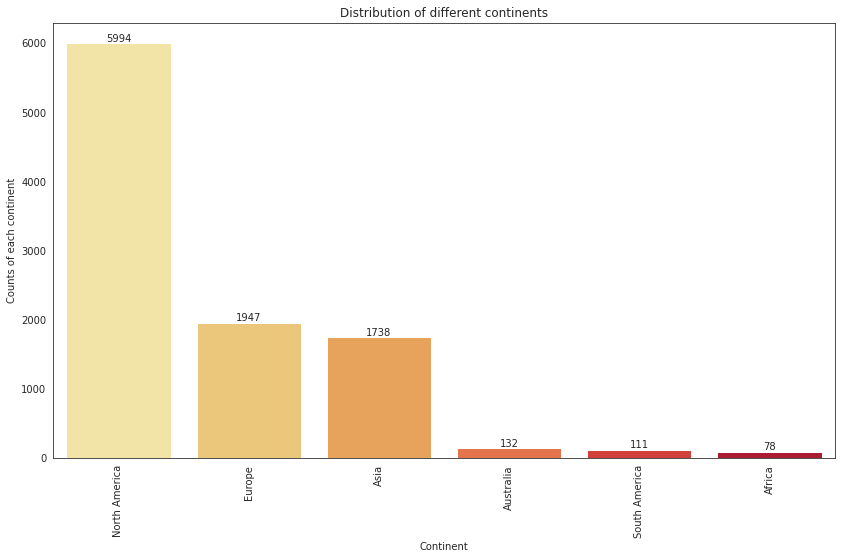

In [30]:
countries_cat_count = df['Headquaters'].value_counts()
countries_cat_count = countries_cat_count.sort_values(ascending = False)
print('There are a total of ',len(countries_cat_count),'different continents in our dataset')

countries_cat_count = countries_cat_count.iloc[:30]
print(countries_cat_count)

plot_bar_plot(countries_cat_count, "Distribution of different continents", "Continent", "Counts of each continent", 'YlOrRd', 'Headquaters.png')


## 3. Clean Sectors

In [31]:
sectors = join_column_vals(df,'Type',',')
sector_cat_count = sectors['Type'].unique()
len(sector_cat_count)

675

Found 675 unique sectors. Need to group up these sectors

In [0]:
# Group sectors to consider only upto 7 sectors for a company

def group_types(df):
  types = []
  for type in df['Type']:
    sep = ','
    rest = ""
    if len(type.split(sep)) > 7:
      rest = type.split(sep)[1] + ',' + type.split(sep)[2] + ',' + type.split(sep)[3] + ',' + type.split(sep)[4] + ',' + type.split(sep)[5] + ',' + type.split(sep)[6] + ',' + type.split(sep)[7]
    elif len(type.split(sep)) > 6:
      rest = type.split(sep)[1] + ',' + type.split(sep)[2] + ',' + type.split(sep)[3] + ',' + type.split(sep)[4] + ',' + type.split(sep)[5] + ',' + type.split(sep)[6]
    elif len(type.split(sep)) > 5:
      rest = type.split(sep)[1] + ',' + type.split(sep)[2] + ',' + type.split(sep)[3] + ',' + type.split(sep)[4] + ',' + type.split(sep)[5]
    elif len(type.split(sep)) > 4:
      rest = type.split(sep)[1] + ',' + type.split(sep)[2] + ',' + type.split(sep)[3] + ',' + type.split(sep)[4]
    elif len(type.split(sep)) > 3:
      rest = type.split(sep)[1] + ',' + type.split(sep)[2] + ',' + type.split(sep)[3]
    elif len(type.split(sep)) > 2:
      rest = type.split(sep)[1] + ',' + type.split(sep)[2] 
    elif len(type.split(sep)) > 1:
      rest = type.split(sep)[1]
    else:
      rest = type.split(sep)[0]
    types.append(rest)
  df['Type'] = types

group_types(df)

#find top 25 sectors overall
sectors_count = join_and_count(df,'Type',',',False)
top_sectors = sectors_count[0:25]

#replace entire dataframe with top 25 sectors
df['Type'] = replace_with_top_n(df,top_sectors,'Type',',','Other')

There are 26 different sectors of Businesses in our Dataset


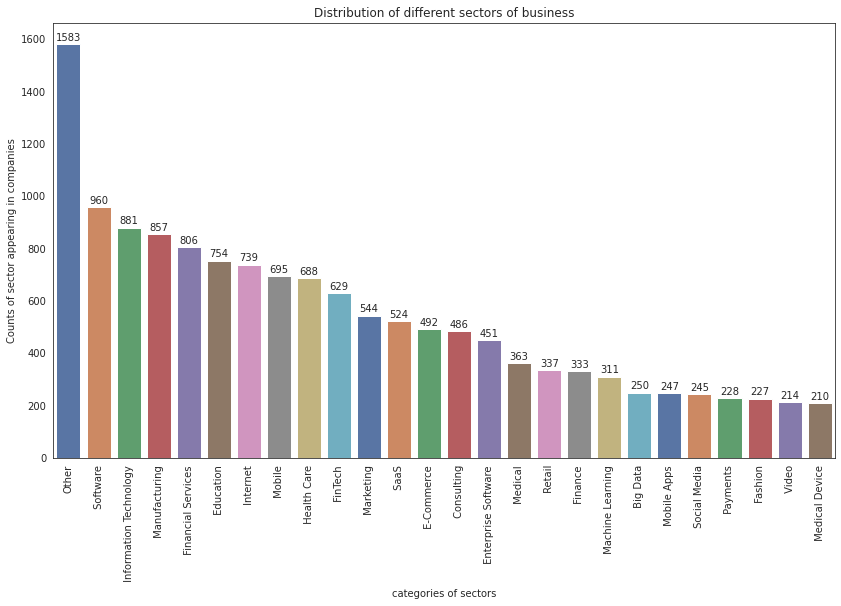

In [33]:
#plot distribution
sector_cat_count = sectors_count = join_and_count(df,'Type',',',False)
print('There are',len(sector_cat_count),'different sectors of Businesses in our Dataset')
plot_bar_plot(sector_cat_count, 'Distribution of different sectors of business', 'categories of sectors', 
              'Counts of sector appearing in companies', 'deep', 'Sectors.png')


## 4. Clean Funding Amount

In [34]:
# #convert vales of different currency to USD 

from currency_converter import CurrencyConverter

def get_symbol(price):
      import re
      pattern =  r'(\D*)\d*\.?\d*(\D*)'
      g = re.match(pattern,price).groups()
      return g[0] 
 

c = CurrencyConverter()
converted_amount = []
for price in df['Funding Amount']:
    if isinstance(price, float):
        converted_amount.append(int(0))
        continue
    symbol = get_symbol(price)
    prc = price.replace(symbol, "").replace(",", "")
    prc = int(prc)
    if symbol == '£':
        prc = c.convert(prc, 'GBP','USD')
    elif symbol == '€':
        prc = c.convert(prc, 'EUR','USD')
    elif symbol == 'IDR':
        prc = c.convert(prc, 'IDR','USD')
    elif symbol == 'NOK':
        prc = c.convert(prc, 'NOK','USD')
    elif symbol == 'PLN':
        prc = c.convert(prc, 'PLN','USD')
    elif symbol == 'CN¥':
        prc = c.convert(prc, 'CNY','USD')
    elif symbol == 'MYR':
        prc = c.convert(prc, 'MYR','USD')
    elif symbol == 'PHP':
        prc = c.convert(prc, 'PHP','USD')
    elif symbol == 'CA$':
        prc = c.convert(prc, 'CAD','USD')
    elif symbol == 'RUB':
        prc = c.convert(prc, 'RUB','USD')
    elif symbol == 'SEK':
        prc = c.convert(prc, 'SEK','USD')
    elif symbol == 'CHF':
        prc = c.convert(prc, 'CHF','USD')
    elif symbol == 'ISK':
        prc = c.convert(prc, 'ISK','USD')
    elif symbol == 'TRY':
        prc = c.convert(prc, 'TRY','USD')
    elif symbol == 'SGD':
        prc = c.convert(prc, 'SGD','USD')
    elif symbol == 'ZAR':
        prc = c.convert(prc, 'ZAR','USD')
    elif symbol == 'DKK':
        prc = c.convert(prc, 'DKK','USD')
    elif symbol == 'A$':
        prc = c.convert(prc, 'AUD','USD')
    elif symbol == '₹':
        prc = c.convert(prc, 'INR','USD')
    elif symbol == 'R$':
        prc = c.convert(prc, 'BRL','USD')
    elif symbol == '¥':
        prc = c.convert(prc, 'JPY','USD')
    elif symbol == '₩':
        prc = c.convert(prc, 'KRW','USD')
    elif symbol == 'MX$':
        prc = c.convert(prc, 'MXN','USD')
    elif symbol == 'NZ$':
        prc = c.convert(prc, 'NZD','USD')
    elif symbol == '₪':
        prc = c.convert(prc, 'ILS','USD')
    elif symbol != '$':
        df = df[df['Funding Amount'] != price]
        continue
    else:
        converted_amount.append(prc)
        continue
    prc = round(prc)
    converted_amount.append(prc)

In [0]:
#Categorize Funding Amount
cc_amount = pd.cut(converted_amount,bins=[-1,1000000,10000000,100000000,30079814466],
       labels=['Less than $1M','$1M to $10M','$10M to 100M','100M+'])
df['Funding Amount'] = cc_amount

There are 4 different Funding Amount Range in our Dataset


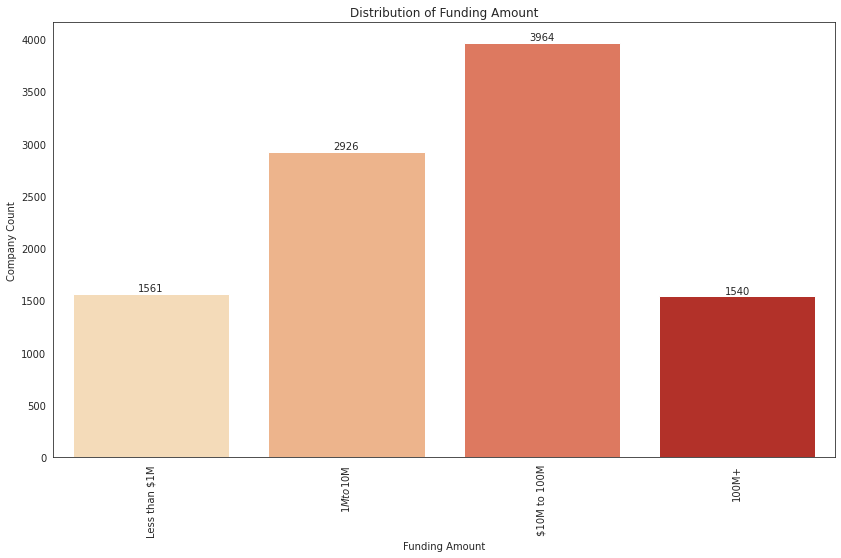

In [36]:
amt_count = df['Funding Amount'].value_counts()
print('There are',len(amt_count),'different Funding Amount Range in our Dataset')
plot_bar_plot(amt_count, 'Distribution of Funding Amount', 'Funding Amount', 
              'Company Count', 'OrRd', 'Funding_Amount.png')

## 5. Exit Year

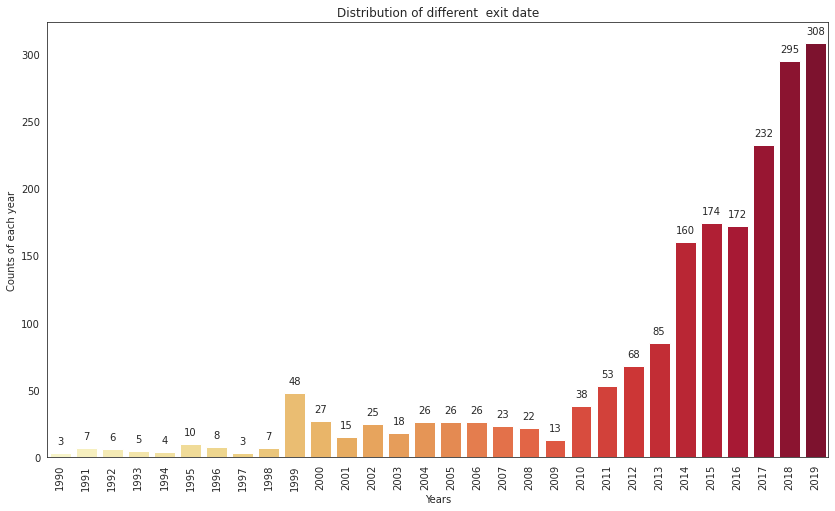

In [37]:

founded_y = []
founded1 =[]
leny = []
df['Exit Date'].fillna(" ", inplace = True)
for i in df['Exit Date']:
  i = i.split(' ')
  founded_y.append(i)

for i in founded_y:
  if(len(i)==3):
    founded1.append(i[2])
  elif(len(i)==2):
    founded1.append(i[1])
  elif(len(i)==1):
    founded1.append(i[0])


year_counts = np.unique(founded1,return_counts=True)


year_counts1 = year_counts[0][:-1]
year_counts1_c = year_counts[1][:-1]

year_counts1 = year_counts1[::-1]
year_counts1_c = [int(i) for i in year_counts1_c]
year_counts1_c = year_counts1_c[::-1]

year_counts1 = year_counts1[0:30]
year_counts1_c = year_counts1_c[0:30]


plt.figure(figsize=(14,8))
bar_year = sns.barplot(x =year_counts1, y = year_counts1_c,palette="YlOrRd")
sns.set_style("white")
plt.title('Distribution of different  exit date')
plt.xlabel('Years')
plt.ylabel('Counts of each year')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)


for i,j in zip(bar_year.patches,year_counts1_c[::-1]):
  height = i.get_height()
  bar_year.text(i.get_x() + i.get_width()/2, height + 5, j, ha='center', va='bottom')
plt.show()
df['Exit Date'] = founded1

## 6. Clean Job Title

In [0]:
# Categorize Job Titles into Most common 6 Titles

df['Job Title'].fillna("Other", inplace = True) 
df['Job Title'] =  df['Job Title'].apply(lambda x: x.upper().replace('AND','&').replace(',','&').replace('/','&').replace('|','&').replace('+','&').replace(' & ','&').strip())

In [0]:
# Categorize common Bizzare words into particular job title
df['Job Title'] = df['Job Title'].replace({'|'.join(['CHIEF EXECUTIVE OFFICER','CHIEF EXECUTIVE','C.E.O','CEO (CEO)','CEO (EMEA)',
                                                      'CEO INTERNATIONAL','CEO CO-FOUNDER','CEO (CEO)','FOUNDER (CEO)','CEO CROSSBORDER',
                                                     'CEO - HYPERGIANT INDUSTRIES','CEO - HYPERGIANT INDUSTRIES','FOUNDING CEO','CEO OF BLIZZARD ENTERTAINMENT',
                                                     'CEO (FMR. CTO)','CEO OF 3D NANO BATTERIES LLC','MD - CEO','CEO OF 3D NANO BATTERIES LLC','CO-CEO',
                                                     'CEO OF STITCH','CEO OFFCER','CO - CEO','FOUNDER - CEO','CEO TECHHUB','FOUNDER I CEO','CEO IN RESIDENCE'
                                                     ]):'CEO'},regex=True)


df['Job Title'] = df['Job Title'].replace({'|'.join(['CO FOUNDER','COFOUNDER','CO - FOUNDER','CO- FOUNDER','CO-FOUNDER','CO -FOUNDER',
                                                               'CO-FOUNDER - MYPROTEIN GROUP','CO-FOUNDER','MEMBER OF FOUNDING TEAM','TITLECO-FOUNDER',
                                                               'CO-FOUNDER - STARTUPBOOTCAMP AFRICA','FOUNDER']):'CO-FOUNDER'},regex=True)

df['Job Title'] = df['Job Title'].replace({'|'.join(['CHIEF TECHNOLOGY OFFICER','CHIEF TECHNICAL OFFICER','CTO SOFTWARE','CHIEF TECHNOLOGY','CTO'
                                                     ]):'CTO'},regex=True)
df['Job Title'] = df['Job Title'].replace({'|'.join(['CHIEF OPERATING OFFICER']):'COO'},regex=True)
df['Job Title'] = df['Job Title'].replace({'|'.join(['CHIEF PRODUCT OFFICER','CPO ITALY']):'CPO'},regex=True)

df['Job Title'] = df['Job Title'].replace({'|'.join(['VICE PRESIDENT','VICE PRESIDENT OF ENGINEERING','VP OF RESEARCH','VP OF STRATEGIC BUSINESS DEVELOPMENT',
                                                      'VP IMAGING SYSTEMS','VP BUSINESS DEVELOPMENT','CORPORATE VICE PRESIDENT','VP OF ENGINEERING','VP OF PRODUCT',
                                                      'VP OF LEARNING AT WORK','VP BUSINESS DEVELOPMENT','VP PRODUCT','VP ENGINEERING','VP MARKETING','VP PRODUCT MANAGEMENT',
                                                      'VP MACHINE LEARNING','EXECUTIVE VICE-PRESIDENT','VICE-PRESIDENT','VP OPERATIONS','VP R','VP MANAGEMENT','VP - COMMERCIAL',
                                                      'VP OF GROWTH','VP OF TECHNOLOGY','VP OF OPS','VP CONTENT','VP MANAGEMENT','VP OF PRODUCT','VP OF TECHNOLOGY',
                                                      'VP OF INVESTMENTS','VP TECHNOLOGY','VP OF PROFESSIONAL SERVICES','VP DATA','VP OF INNOVATION','VP OF GROWTH'
                                                      'VP OF STRATEGIC BUSINESS DEVELOPMENT','VP OF ALGORITHMS','VP - ENTERPRISE DEVELOPMENT','VP OF SPECIAL PROJECTS (POSTMATES X)',
                                                      'V.P. MATERIALS DEVELOPMENT','VP OF STRATEGIC INITIATIVES','VP STRATEGY','CORPORATE VP',
                                                     'VP OF INVESTOR RELATIONS']):'VP'},regex=True)

df['Job Title'] = df['Job Title'].replace({'|'.join(['CHIEF MARKETING OFFICER']):'CMO'},regex=True)
df['Job Title'] = df['Job Title'].replace({'|'.join(['CHIEF FINANCIAL OFFICER']):'CFO'},regex=True)
df['Job Title'] = df['Job Title'].replace({'|'.join(['CHIEF COMMERCIAL OFFICER']):'CCO'},regex=True)

df['Job Title'] = df['Job Title'].replace({'|'.join(['MANAGING DIRECTOR','DIRECTOR','MANAGING DIRECTOR SOUTHEAST ASIA','MANAGING DIRECTOR OPERATIONS',
                                                     'GLOBAL MD','MD MIDDLE EAST INTERNET GROUP','BUSINESS DEVELOPMENT MD','MEDICAL MD',
                                                     'NON-EXECUTIVE MD','CREATIVE MD OF ADVERTISING','EXECUTIVE MD OF THE HYPERLEDGER PROJECT',
                                                     'MD OF ENGINEERING','MD OF MARKETING','FINANCE MD','CREATIVE MD','MD OF FINANCE','GENERAL MD',
                                                     'MD HONG KONG','MD OF R','MD OF THE STANFORD AI LAB','MD OF GLOBAL ACQUIRING','REGIONAL MD'
                                                     'GROUP MD','PROGRAM MD','MD OF PURCHASING','MD OF GLOBAL FINANCIAL SOLUTIONS','MD OF SPECIAL PROJECTS',
                                                     'TECHNICAL MD','MD OF BD','SR. MD','PRESIDENT MD','SENIOR MD OF INVESTMENTS','MD OF TECHNOLOGY',
                                                     'MD OPERATIONS','MD OF PRODUCT','REGIONAL MD','FOUNDING MD']):'MD'},regex=True)

df['Job Title'] = df['Job Title'].replace({'|'.join(['BOARD MEMBER','CHAIRMAN OF THE BOARD','BOARD OF DIRECTORS','MEMBER OF THE BOARD OF DIRECTORS',
                                                               'CHAIRMAN OF THE BOARD OF DIRECTORS','BOARD DIRECTOR','MEMBER OF THE BOARD','BOARD MEMBERS',
                                                               'BOD OF DIRECTORS','BOARD CHAIRMAN','MEMBER OF BOARD','BOARD OF DIRECTER','BOD OF MDS',
                                                                'BOARD OF MDS','BOARD OF MD','ADVISORY BOD','CHAIRMAN OF BOD','BOARD MD','BOARD OF OVERSEERS'
                                                     ]):'BOD'},regex=True)

df['Job Title'] = df['Job Title'].replace({'|'.join(['SENIOR VP','SENIOR VP OF MANUFACTURING','SVP OF SALES','VP OF ENTREPRENEURSHIP','SPV','SVP DIGITAL PRODUCT',
                                                     'SPV OF PRODUCT','SVP OF R','SPV OF MARKETING','SR. VP','SVP OF MANUFACTURING','SVP INNOVATION']):'SVP'},regex=True)



In [0]:
# Top 6 titles
title_count = join_and_count(df,'Job Title','&',False)
top_titles = title_count[0:6]

#replace entire dataframe with top 6 Job titles
df['Job Title'] = replace_with_top_n(df,top_titles,'Job Title','&','OTHER')


There are 6 different Job titles  in our Dataset


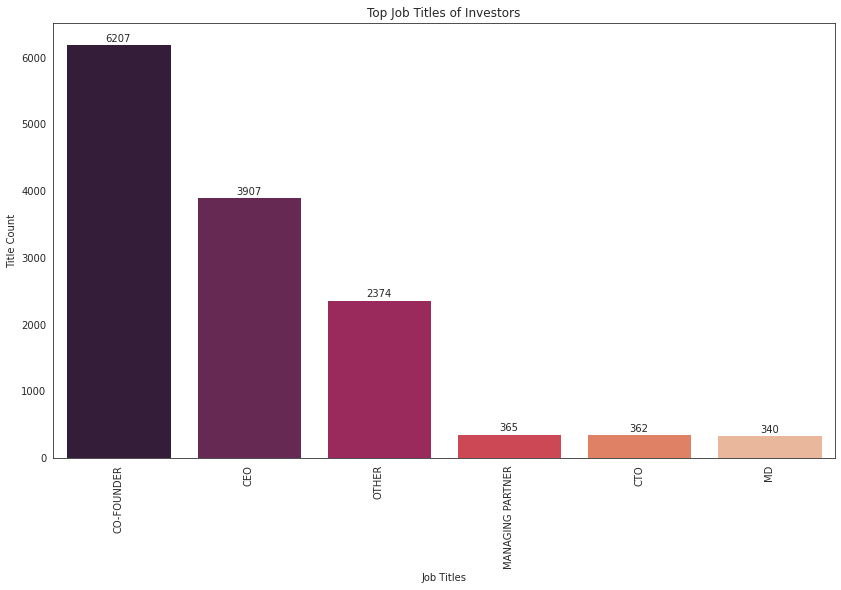

In [41]:
title_count = join_and_count(df,'Job Title','&',False)
print('There are',len(title_count),'different Job titles  in our Dataset')
plot_bar_plot(title_count, "Top Job Titles of Investors", 'Job Titles', "Title Count", 'rocket', 'Job Titles.png')


## 7. Bin Number of Employees

In [0]:
#Categorize number of Employees

df['Number of employees'].replace(np.nan,'11-50',inplace = True)
df['Number of employees'].replace('1-10','<10',inplace = True)
df['Number of employees'].replace('11-50','11-50',inplace = True)
df['Number of employees'].replace('51-100','50-100',inplace = True)

df['Number of employees'].replace('101-250','100-500',inplace = True)
df['Number of employees'].replace('251-500','100-500',inplace = True)

df['Number of employees'].replace('501-1000','500-5000',inplace = True)
df['Number of employees'].replace('1001-5000','500-5000',inplace = True)

df['Number of employees'].replace('5001-10000','>5000',inplace = True)
df['Number of employees'].replace('10001+','>5000',inplace = True)


11-50       4107
100-500     1981
50-100      1367
<10         1124
500-5000     952
>5000        460
Name: Number of employees, dtype: int64
There are a total of  6 different employee categories in our dataset


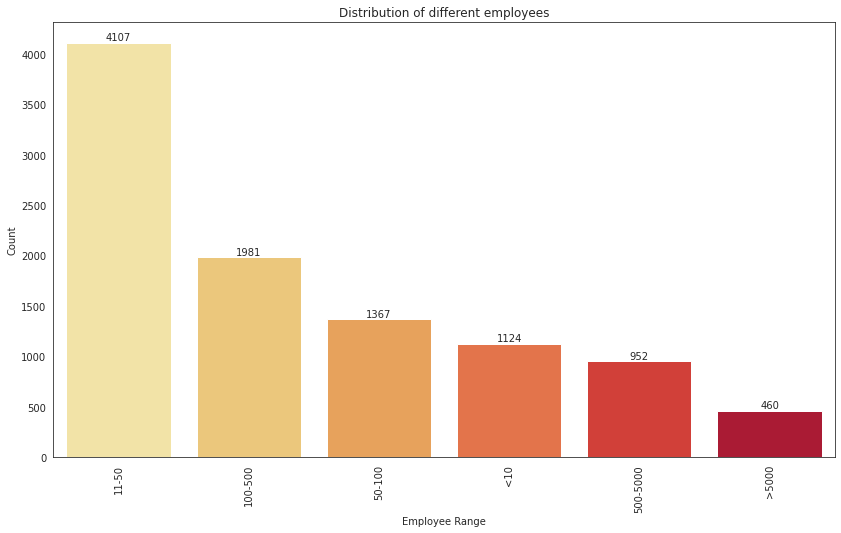

In [43]:
emp_count = df['Number of employees'].value_counts()
print(emp_count)
print('There are a total of ',len(emp_count),'different employee categories in our dataset')
plot_bar_plot(emp_count, 'Distribution of different employees', "Employee Range", "Count", 'YlOrRd', 'Num_Emp.png')


## 8. Bin Number of Estimated Revenue

In [44]:
#Estimated Revenue Categorization


df['Estimated Revenue'].replace('Less than $1M','Less than $1M',inplace = True)

df['Estimated Revenue'].replace('$1M to $10M','$1M - $10M',inplace = True)

df['Estimated Revenue'].replace('$10M to $50M','$10M - $100M',inplace = True)
df['Estimated Revenue'].replace('$50M to $100M','$10M - $100M',inplace = True)

df['Estimated Revenue'].replace('$100M to $500M','$100M-$1B+',inplace = True)
df['Estimated Revenue'].replace('$500M to $1B','$100M-$1B+',inplace = True)
df['Estimated Revenue'].replace('$1B to $10B','$100M-$1B+',inplace = True)
df['Estimated Revenue'].replace('$10B+','$100M-$1B+',inplace = True)

df['Estimated Revenue'].replace(np.nan,'$1M to $10M',inplace = True) #mode

df['Estimated Revenue'].unique()

array(['$100M-$1B+', '$1M - $10M', '$10M - $100M', 'Less than $1M',
       '$1M to $10M'], dtype=object)

$1M to $10M      3738
$1M - $10M       3089
$10M - $100M     1527
Less than $1M     838
$100M-$1B+        799
Name: Estimated Revenue, dtype: int64
There are a total of  5 different Revenue categories in our dataset


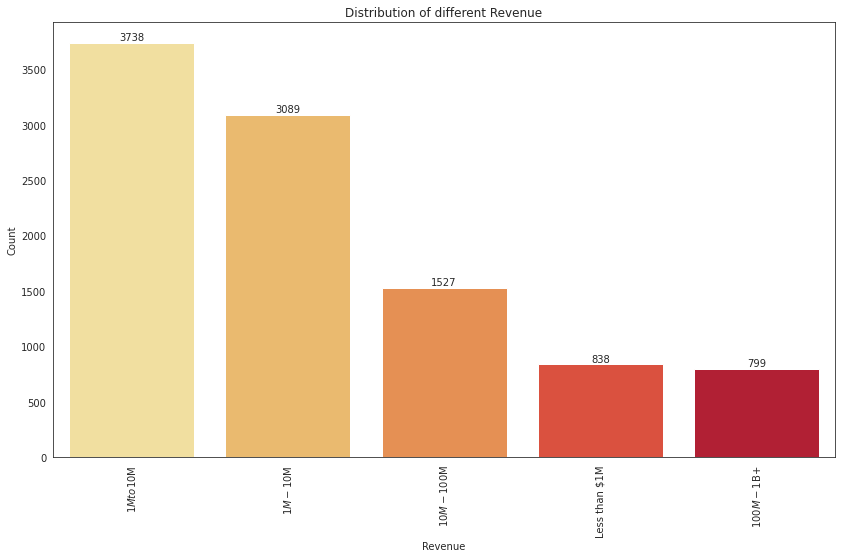

In [45]:
revenue_count = df['Estimated Revenue'].value_counts()
print(revenue_count)
print('There are a total of ',len(revenue_count),'different Revenue categories in our dataset')
plot_bar_plot(revenue_count, 'Distribution of different Revenue', "Revenue", "Count", 'YlOrRd', 'Revenue.png')


## 9. Bin Founders

In [0]:
# Categorize Founders 

df['Founders']= df['Founders'].astype(float) 
df['Founders'] = df['Founders'].fillna('2')
df = df.loc[df['Founders'].astype(float) <= 7]
df['Founders']= df['Founders'].astype(float) 
df['Founders']=pd.cut(df['Founders'], bins=[0,1,2,7], labels = ["1","2","3-7"])

There are a total of  3 different Founder range in our dataset
2      4528
1      2934
3-7    2513
Name: Founders, dtype: int64


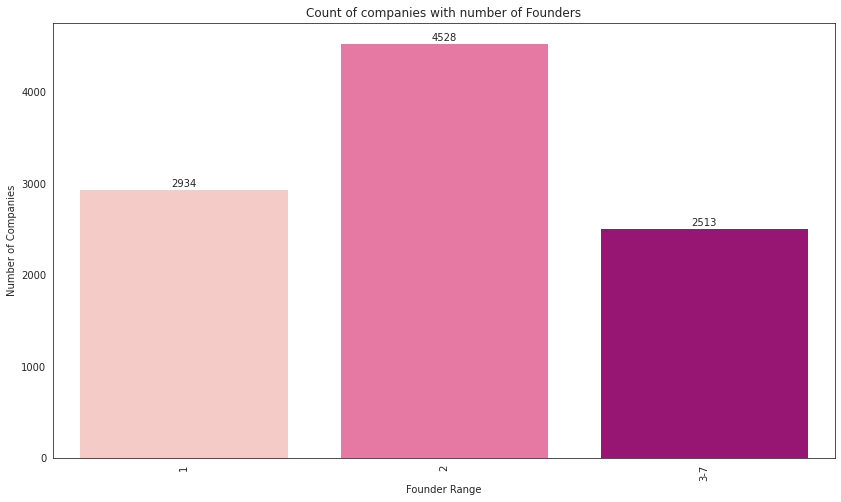

In [47]:
founders_count = df['Founders'].value_counts()
print('There are a total of ',len(founders_count),'different Founder range in our dataset')
print(founders_count)
plot_bar_plot(founders_count, 'Count of companies with number of Founders', "Founder Range", "Number of Companies", 'RdPu', 'Revenue.png')


## 10. Bin Funding Rounds

In [0]:
#binning funding rounds and removed outliers
df['Funding Rounds']= df['Funding Rounds'].astype(float) 
df['Funding Rounds'] = df['Funding Rounds'].fillna('3')
df = df.loc[df['Funding Rounds'].astype(float) <= 13]
df['Funding Rounds']= df['Funding Rounds'].astype(float)
df['Funding Rounds']=pd.cut(df['Funding Rounds'], bins=[0,1,4,13], labels = ["1","2-4","5-13"])

There are a total of  3 different Funding Round Ranges in our dataset
2      4528
1      2934
3-7    2513
Name: Founders, dtype: int64


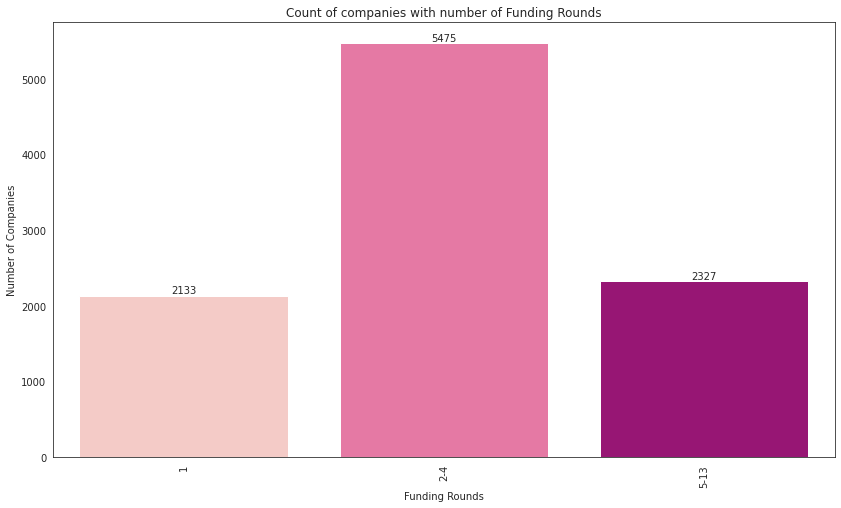

In [49]:
funding_count = df['Funding Rounds'].value_counts()
print('There are a total of ',len(funding_count),'different Funding Round Ranges in our dataset')
print(founders_count)
plot_bar_plot(funding_count, 'Count of companies with number of Funding Rounds', "Funding Rounds", 
              "Number of Companies", 'RdPu', 'funding_rounds.png')


## 11. Bin Number of Lead Investors

In [0]:
#Nunmber of Lead Investors
df['Nunmber of Lead Investors']= df['Nunmber of Lead Investors'].astype(float) 
df['Nunmber of Lead Investors'] = df['Nunmber of Lead Investors'].fillna('2')
df['Nunmber of Lead Investors'] = df['Nunmber of Lead Investors'].astype(float)
df['Nunmber of Lead Investors']=pd.cut(df['Nunmber of Lead Investors'], bins=[0,1,3,15], labels = ["1","2-3","4-15"])

There are a total of  3 different Lead Investors Ranges in our dataset
2-3     5816
1       2842
4-15    1277
Name: Nunmber of Lead Investors, dtype: int64


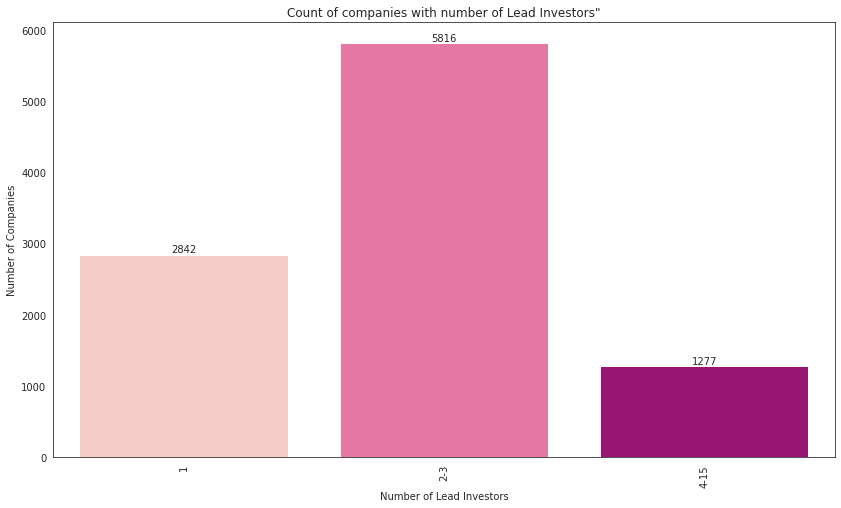

In [51]:
lead_inverstor_count = df['Nunmber of Lead Investors'].value_counts()
print('There are a total of ',len(lead_inverstor_count),'different Lead Investors Ranges in our dataset')
print(lead_inverstor_count)
plot_bar_plot(lead_inverstor_count, 'Count of companies with number of Lead Investors"', "Number of Lead Investors", 
              "Number of Companies", 'RdPu', 'lead_investors.png')


## 12. Bin Number of Investors

In [0]:
#Bining Number of Investors

df['Nmber of Investors']= df['Nmber of Investors'].astype(float) 
df['Nmber of Investors'] = df['Nmber of Investors'].fillna('5')

df['Nmber of Investors'] = df['Nmber of Investors'].astype(float)
df['Nmber of Investors']=pd.cut(df['Nmber of Investors'], bins=[0,1,4,9,104], labels = ["1","2-3","4-20", "21-104"])

There are a total of  4 different Investor Ranges in our dataset
4-20      3935
2-3       2667
21-104    1868
1         1465
Name: Nmber of Investors, dtype: int64


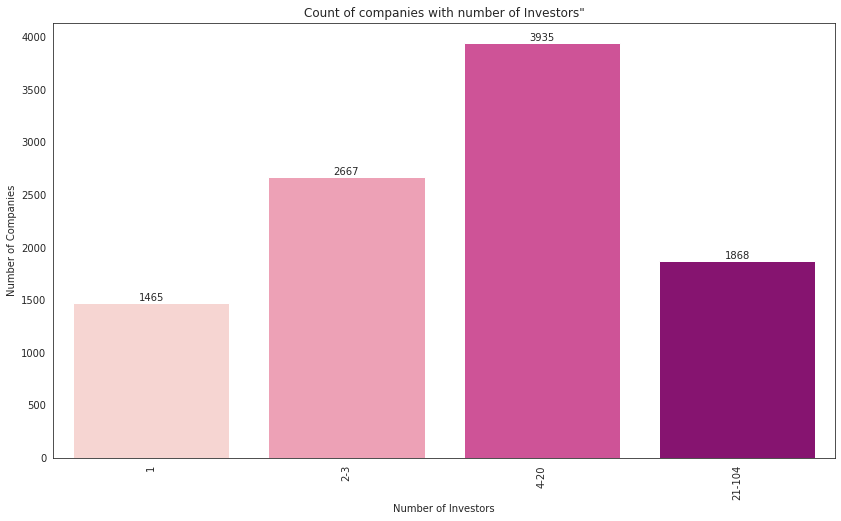

In [53]:
inverstor_count = df['Nmber of Investors'].value_counts()
print('There are a total of ',len(inverstor_count),'different Investor Ranges in our dataset')
print(inverstor_count)
plot_bar_plot(inverstor_count, 'Count of companies with number of Investors"', "Number of Investors", 
              "Number of Companies", 'RdPu', 'investors.png')


## 13. Bin Founded Organizations

In [0]:
#Binning Founded organizations
df['Founded Organization']= df['Founded Organization'].astype(float) 
df['Founded Organization'] = df['Founded Organization'].fillna('2')

df['Founded Organization']  = df['Founded Organization'] .astype(float)
df['Founded Organization'] =pd.cut(df['Founded Organization'] , bins=[0,1,3,23], labels = ["1","2-3","4-23"])

There are a total of  3 different Founded Organization Ranges in our dataset
2-3     4161
1       4091
4-23    1683
Name: Founded Organization, dtype: int64


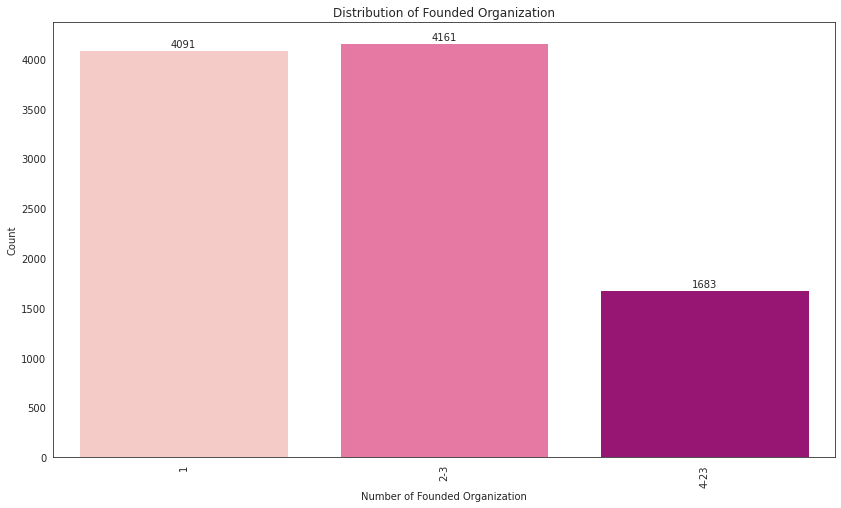

In [55]:
org_count = df['Founded Organization'].value_counts()
print('There are a total of ',len(org_count),'different Founded Organization Ranges in our dataset')
print(org_count)
plot_bar_plot(org_count, 'Distribution of Founded Organization', "Number of Founded Organization", 
              "Count", 'RdPu', 'org.png')


## 14. Bin Portfolio Companies

In [0]:
#binning Portfolio companies

df['Portfolio Companies']= df['Portfolio Companies'].astype(float) 
df['Portfolio Companies'] = df['Portfolio Companies'].fillna('3')

df['Portfolio Companies']  = df['Portfolio Companies'].astype(float)
df['Portfolio Companies'] =pd.cut(df['Portfolio Companies'], bins=[0,2,3,208], labels = ["1-2","3","4-208"])

There are a total of  3 different Portfolio Companies in our dataset
3        7132
1-2      1515
4-208    1288
Name: Portfolio Companies, dtype: int64


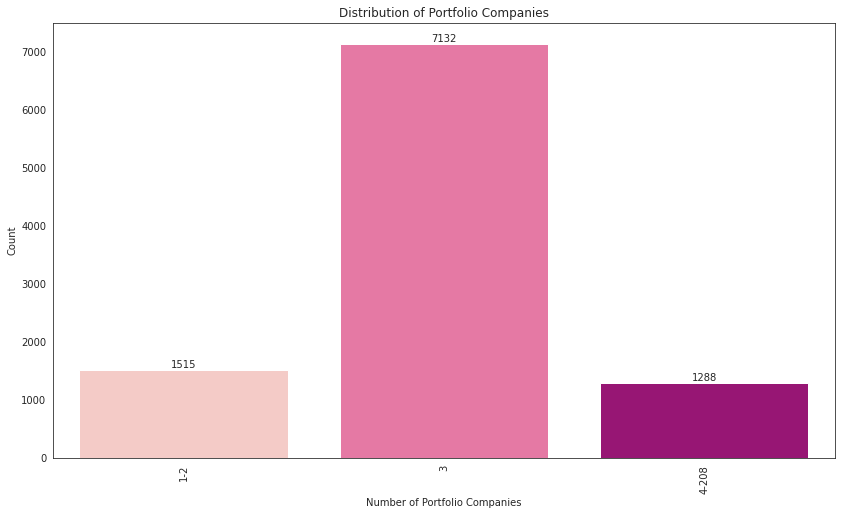

In [57]:
comp_count = df['Portfolio Companies'].value_counts()
print('There are a total of ',len(comp_count),'different Portfolio Companies in our dataset')
print(comp_count)
plot_bar_plot(comp_count, 'Distribution of Portfolio Companies', "Number of Portfolio Companies", 
              "Count", 'RdPu', 'port_comp.png')


# Exploratory Data Analysis

## 1. Relationship between Funding Amount and IPO status

In [58]:
import plotly.express as px
fig = px.box(df, x="IPO status", y="Funding Amount", hover_data= ["IPO status"])
fig.show()

## 2. Distribution of Active Products

There are a total of  4 different continents in our dataset
23-30    4121
11-22    2863
1-10     1716
31-60    1235
Name: Active Products, dtype: int64


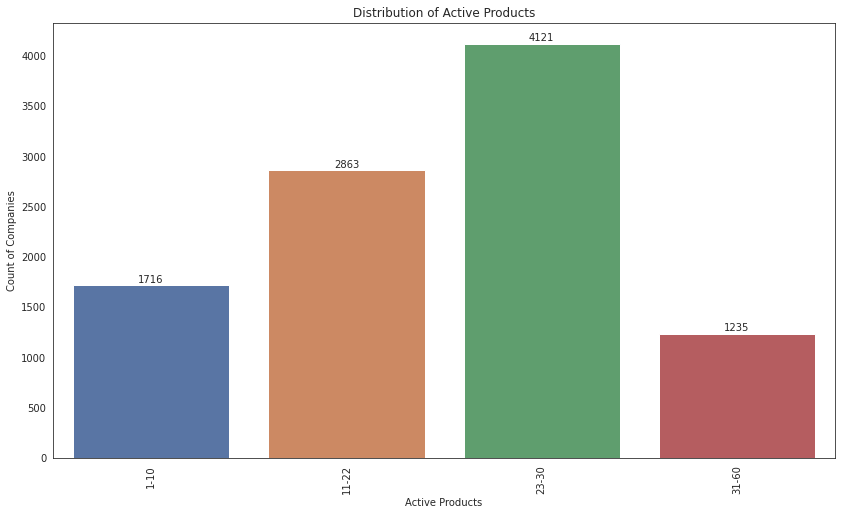

In [59]:
acqstat = df['Active Products'].value_counts()

print('There are a total of ',len(acqstat),'different continents in our dataset')
print(acqstat)

plot_bar_plot(acqstat, "Distribution of Active Products", "Active Products", "Count of Companies", 'deep', 'active_products.png')


In [0]:
#drop unwanted columns
df.to_excel("data_knn.xlsx")
df = df.drop(['Name','Full Name','Number of Lead Investment', 'Investment Stage',
              'Number of Investment','Status','Purpose','Primary Organization'], axis=1)

df.to_excel("data_Model.xlsx")

# Model Building

## Predicting whether a company will take part in Merger or Acquisition Process

### One hot Encoding

In [61]:
df.isnull().sum()

Unnamed: 0                      0
Type                            0
Headquaters                     0
Founded Year                    0
Exit Date                       0
Estimated Revenue               0
Founders                        0
Number of employees             0
Funding Rounds                  0
Funding Status                  0
Active Products                 0
Funding Amount                  0
Nunmber of Lead Investors       0
Nmber of Investors              0
Acquired Price               9501
Acquisitions                 7924
Acquisition Status              0
Acquired By                  8607
IPO status                      0
Job Title                       0
Founded Organization            0
Portfolio Companies             0
dtype: int64

In [0]:
df = pd.read_excel('data_Model.xlsx')
data_model_df = df
df1 = data_model_df['Type'].str.get_dummies(sep=',')
df11 = pd.DataFrame(df1)
df2 = data_model_df['Job Title'].str.get_dummies(sep='&')
df22 = pd.DataFrame(df2)

In [0]:
data_model_df = data_model_df.join(df11)
data_model_df = data_model_df.join(df22)

# df.join(df2)

In [64]:
data_model_df = pd.get_dummies(data_model_df, columns=['Headquaters','Estimated Revenue','Founders',
                                   'Number of employees','Funding Rounds','Funding Status','Active Products','Funding Amount',
                                   'Nunmber of Lead Investors','Nmber of Investors','IPO status','Founded Organization',
                                    'Portfolio Companies','Founded Year','Exit Date'])
data_model_df.head()


,Unnamed: 0,Unnamed: 0.1,Type,Acquired Price,Acquisitions,Acquisition Status,Acquired By,Job Title,Big Data,Consulting,E-Commerce,Education,Enterprise Software,Fashion,FinTech,Finance,Financial Services,Health Care,Information Technology,Internet,Machine Learning,Manufacturing,Marketing,Medical,Medical Device,Mobile,Mobile Apps,Payments,Retail,SaaS,Social Media,Software,Video,Other,CEO,CO-FOUNDER,CTO,MANAGING PARTNER,MD,OTHER,...,Exit Date_1981.0,Exit Date_1982.0,Exit Date_1983.0,Exit Date_1984.0,Exit Date_1985.0,Exit Date_1986.0,Exit Date_1987.0,Exit Date_1988.0,Exit Date_1989.0,Exit Date_1990.0,Exit Date_1991.0,Exit Date_1992.0,Exit Date_1993.0,Exit Date_1994.0,Exit Date_1995.0,Exit Date_1996.0,Exit Date_1997.0,Exit Date_1998.0,Exit Date_1999.0,Exit Date_2000.0,Exit Date_2001.0,Exit Date_2002.0,Exit Date_2003.0,Exit Date_2004.0,Exit Date_2005.0,Exit Date_2006.0,Exit Date_2007.0,Exit Date_2008.0,Exit Date_2009.0,Exit Date_2010.0,Exit Date_2011.0,Exit Date_2012.0,Exit Date_2013.0,Exit Date_2014.0,Exit Date_2015.0,Exit Date_2016.0,Exit Date_2017.0,Exit Date_2018.0,Exit Date_2019.0,Exit Date_2020.0
0,0,0,Enterprise Software,NaN,5.0,Acquisition,NaN,CO-FOUNDER&CEO,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,1,Other,NaN,NaN,No Participation,NaN,CO-FOUNDER&CEO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2,"Marketing, Retail",NaN,9.0,Acquisition,NaN,CO-FOUNDER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,3,"SaaS, Social Media",NaN,12.0,Acquisition,NaN,CEO&CO-FOUNDER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,4,Other,NaN,NaN,No Participation,NaN,OTHER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
data_model_df.head()

,Unnamed: 0,Unnamed: 0.1,Type,Acquired Price,Acquisitions,Acquisition Status,Acquired By,Job Title,Big Data,Consulting,E-Commerce,Education,Enterprise Software,Fashion,FinTech,Finance,Financial Services,Health Care,Information Technology,Internet,Machine Learning,Manufacturing,Marketing,Medical,Medical Device,Mobile,Mobile Apps,Payments,Retail,SaaS,Social Media,Software,Video,Other,CEO,CO-FOUNDER,CTO,MANAGING PARTNER,MD,OTHER,...,Exit Date_1981.0,Exit Date_1982.0,Exit Date_1983.0,Exit Date_1984.0,Exit Date_1985.0,Exit Date_1986.0,Exit Date_1987.0,Exit Date_1988.0,Exit Date_1989.0,Exit Date_1990.0,Exit Date_1991.0,Exit Date_1992.0,Exit Date_1993.0,Exit Date_1994.0,Exit Date_1995.0,Exit Date_1996.0,Exit Date_1997.0,Exit Date_1998.0,Exit Date_1999.0,Exit Date_2000.0,Exit Date_2001.0,Exit Date_2002.0,Exit Date_2003.0,Exit Date_2004.0,Exit Date_2005.0,Exit Date_2006.0,Exit Date_2007.0,Exit Date_2008.0,Exit Date_2009.0,Exit Date_2010.0,Exit Date_2011.0,Exit Date_2012.0,Exit Date_2013.0,Exit Date_2014.0,Exit Date_2015.0,Exit Date_2016.0,Exit Date_2017.0,Exit Date_2018.0,Exit Date_2019.0,Exit Date_2020.0
0,0,0,Enterprise Software,NaN,5.0,Acquisition,NaN,CO-FOUNDER&CEO,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,1,Other,NaN,NaN,No Participation,NaN,CO-FOUNDER&CEO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2,"Marketing, Retail",NaN,9.0,Acquisition,NaN,CO-FOUNDER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,3,"SaaS, Social Media",NaN,12.0,Acquisition,NaN,CEO&CO-FOUNDER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,4,Other,NaN,NaN,No Participation,NaN,OTHER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Down Sampling
Down Sample 1500 samples of "Did Not Participate" due to imbalanced Data

In [0]:
test_data = data_model_df
sample_df = data_model_df[data_model_df['Acquisition Status']=='Merger']
sample_df = sample_df.append(data_model_df[data_model_df['Acquisition Status']=='Acquisition']).sample(n=1000, random_state=1)
sample_df = sample_df.append(data_model_df[data_model_df['Acquisition Status']=='No Participation'].sample(n=1100, random_state=1))
#np.unique(sample_df['Acquisition Status'],return_counts = True)
data_model_df = sample_df


### Mixed Sampling

In [0]:
# test_data = data_model_df
# sample_df = data_model_df[data_model_df['Acquisition Status']=='Did Not Participate'].sample(n=1750, random_state=1,replace=True)
# sample_df = sample_df.append(data_model_df[data_model_df['Acquisition Status']=='WasAcquired'].sample(n=1850, random_state=1,replace=True))
# sample_df = sample_df.append(data_model_df[data_model_df['Acquisition Status']=='MadeAcquisitions'].sample(n=1650, random_state=1,replace=True))
# #np.unique(sample_df['Acquisition Status'],return_counts = True)
# data_model_df = sample_df

In [68]:
data_model_df.shape

(2100, 326)

In [69]:
test_data.shape

(9935, 326)

### Unseen Data

In [0]:
# test_data = test_data.drop(sample_df.index)
# data_model_df = test_data 

### Drop Columns

In [0]:
Acquired_Status = data_model_df['Acquisition Status']
Acquired_price = data_model_df['Acquired Price']
Acquired_By = data_model_df['Acquired By']

In [0]:

data_model_df = data_model_df.drop(['Acquired Price'],axis = 1)
data_model_df = data_model_df.drop(['Acquired By'],axis = 1)
data_model_df = data_model_df.drop(['Acquisition Status'],axis = 1)
data_model_df = data_model_df.drop(['Acquisitions'],axis = 1)
data_model_df = data_model_df.drop(['Type'],axis = 1)
data_model_df = data_model_df.drop(['Job Title'],axis = 1)
data_model_df= data_model_df.drop(['Unnamed: 0'],axis=1)
data_model_df= data_model_df.drop(['Unnamed: 0.1'],axis=1)

### Importing libraries 


In [0]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.metrics import average_precision_score
from sklearn.ensemble import AdaBoostClassifier as ab
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier

from sklearn.linear_model import SGDClassifier as sg
import matplotlib.pyplot as plt
import numpy as np

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_model_df, Acquired_Status, test_size=0.33, random_state=42)

In [75]:
y_train.value_counts()

No Participation    742
Acquisition         555
Merger              110
Name: Acquisition Status, dtype: int64

In [76]:
y_test.value_counts()

No Participation    358
Acquisition         294
Merger               41
Name: Acquisition Status, dtype: int64

### Model Grid
Naive Bayes, KNN, Gradient Boosting , Ada Boost, Decision Tree

In [77]:
model_name=['naive_bayes','RandomForestClassifier','KNeighborsClassifier','GradientBoostingClassifier','AdaBoostClassifier','DecisionTreeClassifier','LogisticRegression']
models_list= [NB(),RF(),KNN(),GB(),ab(),dt(),LR(max_iter=600)]
for i, j in zip(model_name, models_list):
    scores = cross_val_score(j, X_train, y_train, cv=5)
    
    print(i+"--"+ "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

naive_bayes--Accuracy: 0.65 (+/- 0.04)
RandomForestClassifier--Accuracy: 0.74 (+/- 0.02)
KNeighborsClassifier--Accuracy: 0.67 (+/- 0.04)
GradientBoostingClassifier--Accuracy: 0.73 (+/- 0.03)
AdaBoostClassifier--Accuracy: 0.66 (+/- 0.03)
DecisionTreeClassifier--Accuracy: 0.65 (+/- 0.06)
LogisticRegression--Accuracy: 0.74 (+/- 0.05)


### Learning curve

In [0]:
def plot_curve(train_scores,test_scores,train_sizes,fig_name,title,xlabel,ylabel):
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)


  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)


  plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
  plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")


  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

  plt.title(title)
  plt.xlabel(xlabel), 
  plt.ylabel(ylabel), 
  plt.legend(loc="best")
  plt.tight_layout()
  plt.savefig(fig_name, bbox_inches='tight')

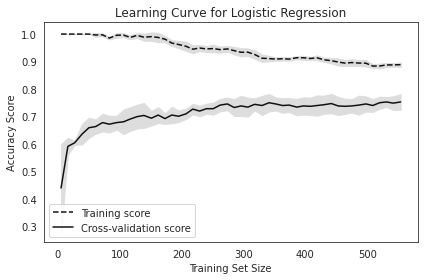

In [79]:
train_sizes, train_scores, test_scores = learning_curve(LR(max_iter = 1000), 
                                                        X_test, 
                                                        y_test,
                                                        cv = 5,
                                                        scoring='accuracy',
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

plot_curve(train_scores,test_scores,train_sizes,"Logistic_Reg_Curve.png",
           "Learning Curve for Logistic Regression","Training Set Size","Accuracy Score")

#### Naive Bayes Learning

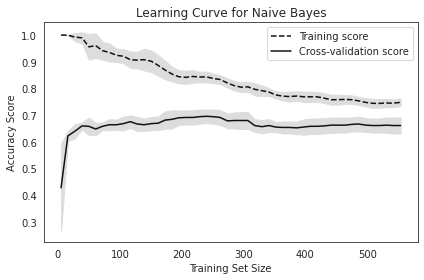

In [80]:
train_sizes, train_scores, test_scores = learning_curve(NB(), 
                                                        X_test, 
                                                        y_test,
                                                        cv = 5,
                                                        scoring='accuracy',                                                
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

plot_curve(train_scores,test_scores,train_sizes,"Naive_Bayes_Curve.png",
           "Learning Curve for Naive Bayes","Training Set Size","Accuracy Score")


#### Decision Tree Learning Curve

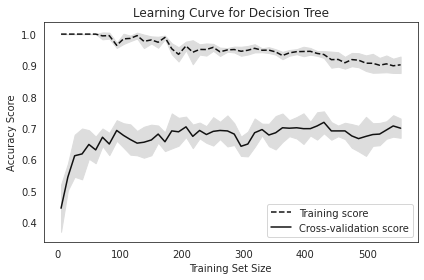

In [81]:
train_sizes, train_scores, test_scores = learning_curve(dt(criterion = 'entropy' ,max_depth = 10), 
                                                        X_test, 
                                                        y_test,
                                                        cv = 5,                                                      
                                                        scoring='accuracy',                                                       
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

plot_curve(train_scores,test_scores,train_sizes,"Decision_Tree_Curve.png",
           "Learning Curve for Decision Tree","Training Set Size","Accuracy Score")


#### Adaboost Learning Curve

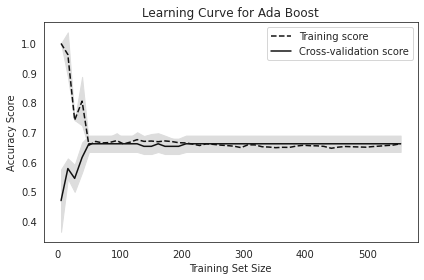

In [82]:
train_sizes, train_scores, test_scores = learning_curve(ab(), 
                                                        X_test, 
                                                        y_test,
                                                        cv = 5,
                                                        scoring='accuracy',                                                       
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

plot_curve(train_scores,test_scores,train_sizes,"Adaboost_Curve.png",
           "Learning Curve for Ada Boost","Training Set Size","Accuracy Score")

### ROC Curve Decision Tree

In [0]:
X = data_model_df
y = Acquired_Status

3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



<Figure size 432x288 with 0 Axes>

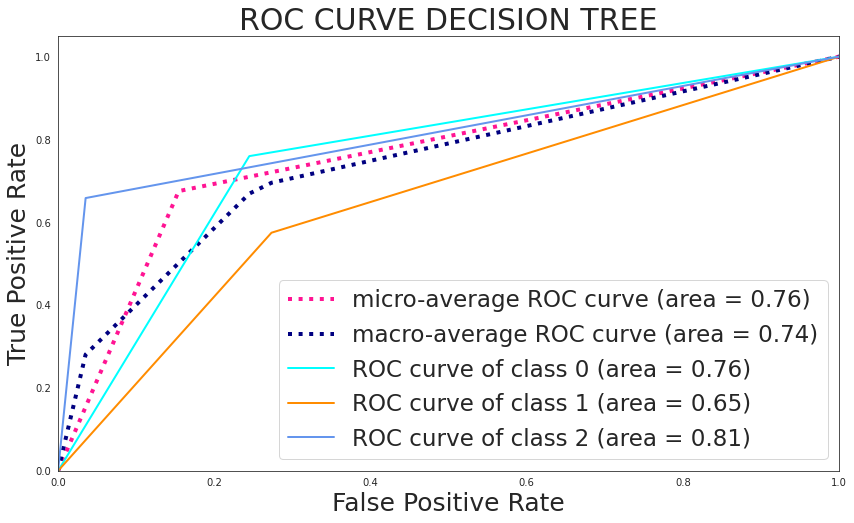

In [84]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score



y_1 = label_binarize(Acquired_Status, classes=['No Participation', 'Acquisition', 'Merger'])
n_classes = y_1.shape[1]
print(n_classes)

random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
# print(df.shape)
X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X, y_1, test_size=0.33, random_state=42)

classifier = OneVsRestClassifier(dt(criterion = 'entropy' ,max_depth = 15))
y_score = classifier.fit(X_train_roc,y_train_roc).predict(X_test_roc)

fpr = dict()
tpr = dict()
roc_auc = dict()
yu = np.unique(Acquired_Status)
for i,v in enumerate(yu):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.figure(figsize=(14,8))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

#plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize = 25)
plt.ylabel('True Positive Rate',fontsize = 25)
plt.title('ROC CURVE DECISION TREE',fontsize = 30)
plt.legend(loc="lower right",prop={'size': 23})
plt.savefig("DT_ROC.png",bbox_inches='tight')

### Confusion Matrix

In [0]:
import seaborn as sns
def print_ConfusionMatrix(actual, pred,score,algo):
  cm = confusion_matrix(actual, pred)
  sns.set(font_scale=2)
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'YlOrRd');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(round(score,4))
  plt.title(all_sample_title)
  plt.savefig(algo, bbox_inches='tight')
 


### Fitting the Decision Tree

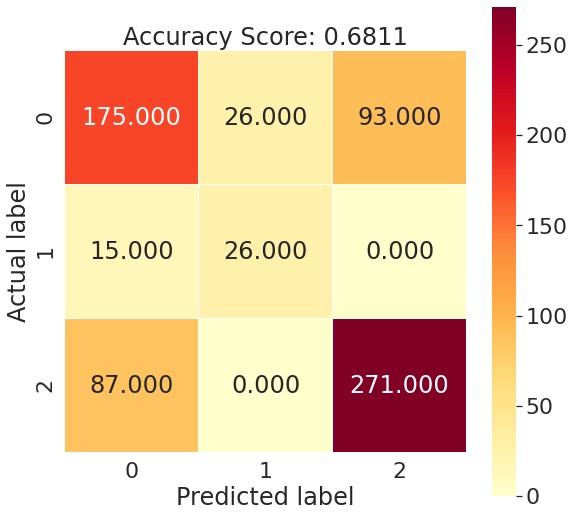

In [86]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion = 'entropy' , random_state=42,max_depth = 25)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score = clf.score(X_test,y_test)
print_ConfusionMatrix(y_test, y_pred,score,'decision_tree.png')
# plt.figure(figsize=(20,18))
# tree.plot_tree(clf)

In [0]:
# y_pred = clf.predict(data_model_df)
# y_test = Acquired_Status
# score = clf.score(data_model_df,y_test)

### Logistic Regression

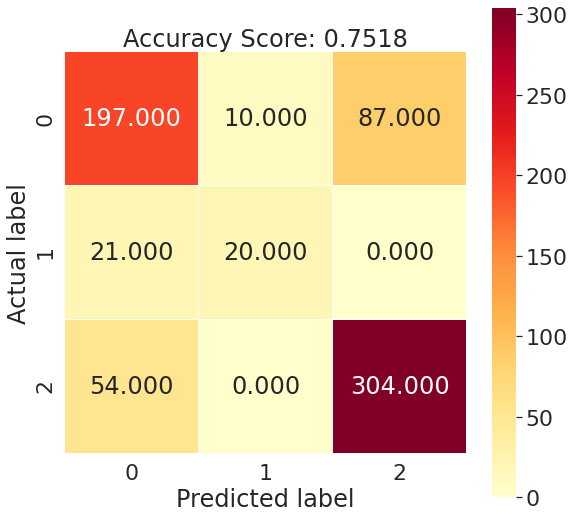

In [88]:
clf = LR(random_state=0,max_iter = 1000).fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
print_ConfusionMatrix(y_test, y_pred,score,"LR_CM.png")

### Random Forest

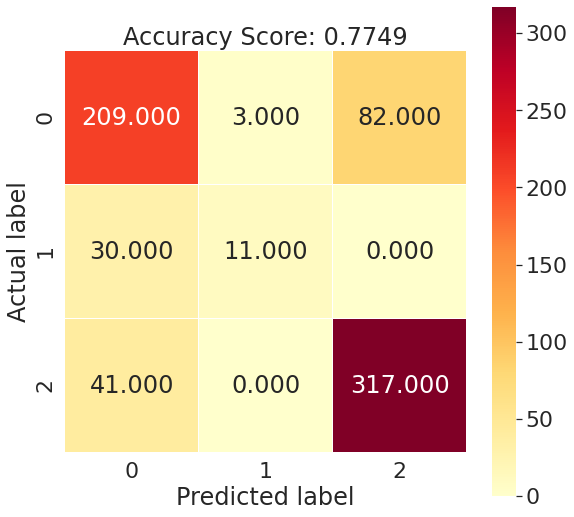

In [89]:
#Random Forest confusion matrix
clf = RF(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
print_ConfusionMatrix(y_test, y_pred,score,"RF.png")

### Precision Recall for Decision Tree

In [90]:
from sklearn.preprocessing import label_binarize

y = Acquired_Status
y = label_binarize(Acquired_Status, classes=['No Participation', 'Acquisition', 'Merger'])
n_classes = y.shape[1]

random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
# print(df.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


classifier = OneVsRestClassifier(dt(criterion = 'entropy' ,max_depth = 15))
y_score = classifier.fit(X_train,y_train).predict(X_test)

from sklearn.multiclass import OneVsRestClassifier
# Run classifier
classifier = OneVsRestClassifier(dt(criterion = 'entropy' ,max_depth = 15))
y_score = classifier.fit(X_train,y_train).predict(X_test)

from sklearn.metrics import precision_recall_curve


# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:,i], y_score[:,i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))


Average precision score, micro-averaged over all classes: 0.56


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.56')

<Figure size 432x288 with 0 Axes>

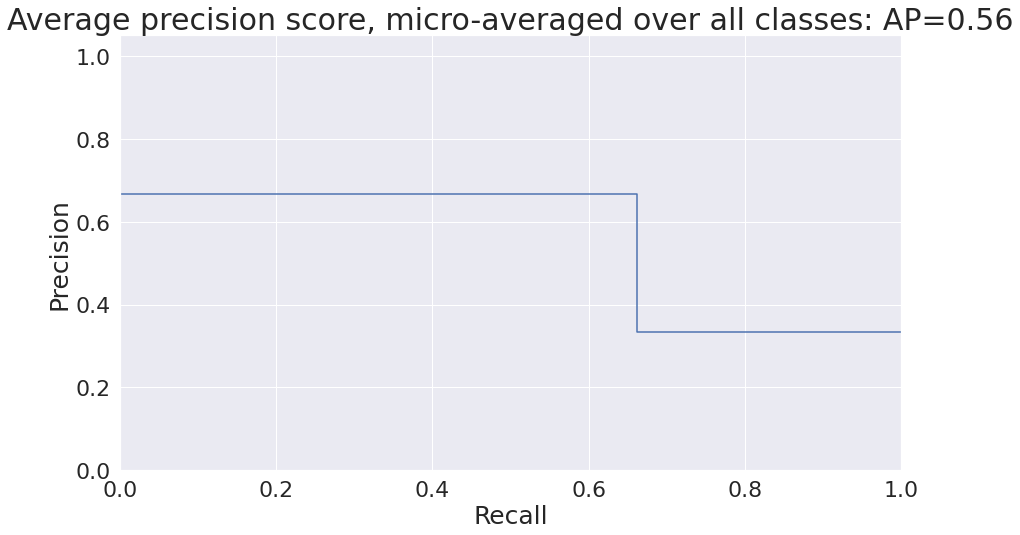

In [91]:
plt.figure()
plt.figure(figsize=(14,8))
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall',fontsize = 25)
plt.ylabel('Precision',fontsize = 25)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]),fontsize=30)

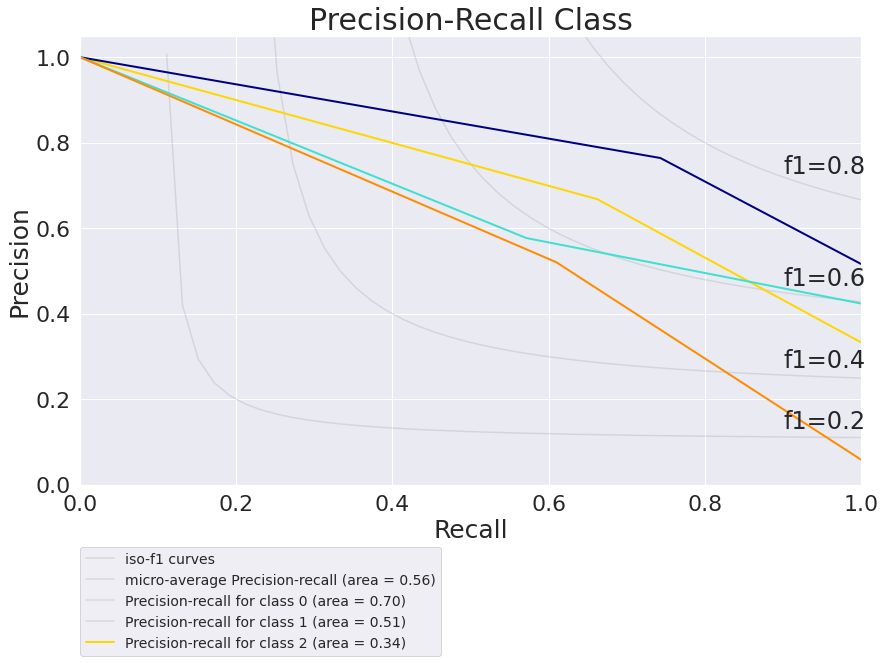

In [92]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(14,8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=25)
plt.ylabel('Precision',fontsize = 25)
plt.title('Precision-Recall Class',fontsize=30)
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))
plt.show()

### Best Subset Selection

In [0]:
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# # Interaction terms
# poly = PolynomialFeatures(degree=2)
# X_train = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names(X.columns))
# X_test = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names(X.columns))
# # Standardize data
# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [0]:
# # Import your necessary dependencies
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# # Feature extraction
# model = LogisticRegression(max_iter = 1000)
# rfe = RFE(model, 14)
# fit = rfe.fit(X_train, y_train)

In [0]:
# from sklearn.feature_selection import RFECV
 
# # RFE
# from sklearn.svm import SVC
# clf = LR(random_state=0,max_iter = 1000)

# rfe = RFECV(estimator=clf, cv=4, scoring='accuracy')
# rfe = rfe.fit(X_train, y_train)
 
# # Select variables and calulate test accuracy
# cols = X_train.columns[rfe.support_]
# acc = accuracy_score(y_test, rfe.estimator_.predict(X_test[cols]))
# print('Number of features selected: {}'.format(rfe.n_features_))
# print('Test Accuracy {}'.format(acc))
 
# # Plot number of features vs CV scores
# plt.figure()
# plt.xlabel('k')
# plt.ylabel('CV accuracy')
# plt.plot(np.arange(1, rfe.grid_scores_.size+1), rfe.grid_scores_)
# plt.show()

In [0]:
# print(X.columns[fit.n_features_])
# idx = np.where(fit.support_ == 1)
# print(X.columns[idx])



In [0]:
# import matplotlib.pyplot as plt
# from sklearn.svm import SVC
# from sklearn.model_selection import StratifiedKFold
# from sklearn.feature_selection import RFECV
# from sklearn.datasets import make_classification



# # Create the RFE object and compute a cross-validated score.
# svc = SVC(kernel="linear")
# # The "accuracy" scoring is proportional to the number of correct
# # classifications
# rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
#               scoring='accuracy')
# rfecv.fit(X, y)

# print("Optimal number of features : %d" % rfecv.n_features_)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

In [0]:
# select = rfecv.get_support()
# idx = np.where(select)
# print(X.columns[idx])

In [0]:
# data_model_best_subset_df = data_model_df[X.columns[idx]]
# data_model_best_subset_df.head()
# X_train, X_test, y_train, y_test = train_test_split(data_model_best_subset_df, Acquired_Status, test_size=0.33, random_state=42)

In [0]:
# model_name=['naive_bayes','RandomForestClassifier','KNeighborsClassifier','GradientBoostingClassifier','AdaBoostClassifier','DecisionTreeClassifier','LogisticRegression']
# models_list= [NB(),RF(),KNN(),GB(),ab(),dt(),LR(max_iter=600)]
# for i, j in zip(model_name, models_list):
#     scores = cross_val_score(j, X_train, y_train, cv=5)
    
#     print(i+"--"+ "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## Recommendation System 
Predicting the best companies, a company should participate with for a profitable Merger or Acquisition

In [100]:
data_model_df = pd.read_excel('data_Model.xlsx')
sample_df = data_model_df[data_model_df['Acquisition Status']=='Merger']
sample_df = sample_df.append(data_model_df[data_model_df['Acquisition Status']=='Acquisition']).sample(n=1000, random_state=1)
sample_df = sample_df.append(data_model_df[data_model_df['Acquisition Status']=='No Participation'].sample(n=1100, random_state=1))
#np.unique(sample_df['Acquisition Status'],return_counts = True)
df = sample_df

extra = df
extra.shape


(2100, 23)

In [0]:

df= df.drop(['Unnamed: 0'],axis=1)
df = df.drop(['Unnamed: 0.1'],axis = 1)
df = df.drop(['Job Title'],axis = 1)
df = df.drop(['Acquired Price'],axis = 1)

df = pd.get_dummies(df, columns=['Headquaters','Estimated Revenue','Founders',
                                   'Number of employees','Funding Rounds','Funding Status','Active Products','Funding Amount',
                                   'Nunmber of Lead Investors','Nmber of Investors','IPO status','Founded Organization','Acquired By','Acquisition Status','Acquisitions',
                                    'Portfolio Companies','Founded Year','Exit Date'])

df1 = df['Type'].str.get_dummies(sep=',')
df11 = pd.DataFrame(df1)

df = df.drop(['Type'],axis = 1)

df = df.join(df11)

### Calculating the cost for number of clusters and plotting it

In [0]:
extra.dtypes
extra= extra.drop(['Unnamed: 0'],axis=1)
extra = extra.drop(['Unnamed: 0.1'],axis = 1)
extra = extra.drop(['Founded Year'],axis = 1)
extra = extra.drop(['Exit Date'],axis = 1)
extra = extra.drop(['Job Title'],axis = 1)
extra = extra.drop(['Acquired Price'],axis = 1)
extra = extra.drop(['Acquired By'],axis = 1)
extra = extra.drop(['Acquisitions'],axis = 1)


In [112]:
#kmodes

from kmodes.kmodes import KModes

km = KModes(n_clusters=8, init='Huang', n_init=8, verbose=1)
clusters = km.fit_predict(df)


# Print the cluster centroids
print(km.cluster_centroids_)


#ploting
cost = pd.DataFrame(km.epoch_costs_, columns=['cost'])
cc= pd.DataFrame(range(len(km.epoch_costs_)), columns=['index'])
cost1 = cc.join(cost)
print(cost1)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 803, cost: 27235.0
Run 1, iteration: 2/100, moves: 395, cost: 26922.0
Run 1, iteration: 3/100, moves: 264, cost: 26856.0
Run 1, iteration: 4/100, moves: 9, cost: 26856.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 912, cost: 27568.0
Run 2, iteration: 2/100, moves: 293, cost: 27398.0
Run 2, iteration: 3/100, moves: 248, cost: 27258.0
Run 2, iteration: 4/100, moves: 61, cost: 27258.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 766, cost: 26915.0
Run 3, iteration: 2/100, moves: 136, cost: 26867.0
Run 3, iteration: 3/100, moves: 23, cost: 26867.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 795, cost: 27948.0
Run 4, iteration: 2/100, moves: 299, cost: 27787.0
Run 4, iteration: 3/1

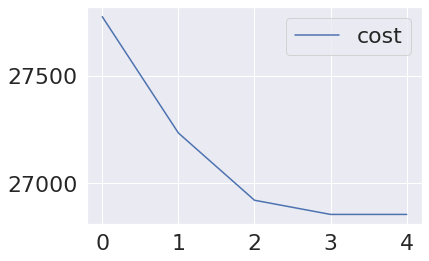

In [113]:
cost.plot.line()

### 3-NN

In [114]:
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(df.values)
# movie_features_df_matrix.shape
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute',radius = 1.5)
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.5)

In [115]:
dfold = pd.read_excel('Data_knn.xlsx')


sectors = dfold.iloc[:,1:3]

print(sectors)
query_index = np.random.choice(df.shape[0])
print(query_index)
print(sectors.loc[query_index]['Name'])
print(sectors.loc[query_index]['Type'])


                              Name                                               Type
0                  1.  Cloudflare    Ad Server, Advertising, Analytics, Enterprise...
1                      2.  GumGum    Advertising, Advertising Platforms, Analytics...
2      3.  Authentic Brands Group     Advertising, Brand Marketing, Marketing, Retail
3                   4.  Hootsuite    Advertising, Apps, Brand Marketing, Messaging...
4                        5.  Tubi    Advertising, Digital Entertainment, Film, Med...
...                            ...                                                ...
9995               196.  Emailage    Air Transportation, Artificial Intelligence, ...
9996              197.  Gainsight                 Enterprise Software, SaaS, Software
9997                  198.  JFrog    Developer Tools, Enterprise Software, Softwar...
9998               199.  Homebase    Human Resources, Local, Professional Services...
9999                   200.  Quip    Collaboration, En

In [116]:
distances, indices = model_knn.kneighbors(df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 4)
distances = distances[0][1:6]
indices = indices[0][1:6]
print(distances,indices)

[0.27239312 0.27239312 0.29411765] [1697 1057  768]


In [117]:
print('Prediction for : ',sectors.loc[query_index]['Name'])
print('Sector :',sectors.loc[query_index]['Type'])
print('---------------------------------------------')
print('---------------------------------------------')
for i in indices:
  print('Company it could participate with is : ')
  print('{0} :'.format(sectors.iloc[i]['Name']))
  print('Sector :{0}'.format(sectors.iloc[i]['Type']))
  print('---------------------------------------------')

Prediction for :   208.  Active International 
Sector :  Advertising, Marketing, Retail
---------------------------------------------
---------------------------------------------
Company it could participate with is : 
 198.  Careerminds Group  :
Sector : Consulting, E-Learning, Human Resources
---------------------------------------------
Company it could participate with is : 
 508.  Dinsmore Steele  :
Sector : Consulting, Insurance
---------------------------------------------
Company it could participate with is : 
 219.  Inneractive  :
Sector : Ad Exchange, Advertising, Marketing, Mobile Advertising, Mobile Apps
---------------------------------------------
